#  <br><center>Don't Over Fit II
 
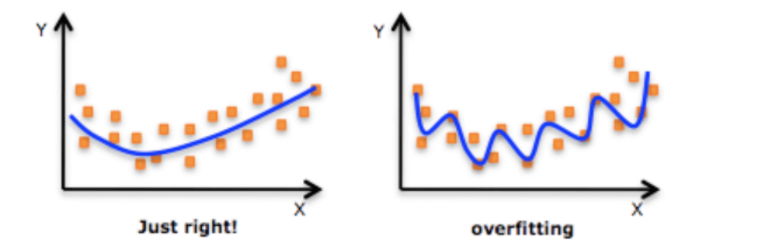
    

## WHY?
1. 최근 개인적으로 모델에 대한 성능을 높이는 것에 대한 관심이 높아졌다.<br> 모델의 성능을 올리려고 하면 Overfitting이 자꾸 일어났다.
2. 이것을 해결하기 위한 방법을 배우고 싶었고 다양한 변수선택(feature selection)의 방법을 배우고 싶었다.

## HOW?
1. Kaggle의 가장많은 vote를 받은 "How to not overfit?"을 참고했다.
2. 총 2번의 노트북을 만들예정이다.
 * ~~첫번째는 "How to not overfit?" 필사~~
 * 두번째는 필사와 여러 노트북, 내가 알고있는 지식을 활용해서 데이터 분석 및 모델링(현재 노트북)
 
## GOAL
1. 여러가지 방법으로 변수선택을 해보겠다.
2. Overfitting이 일어나지 않게 모델의 성능을 올려보겠다.

## 목차
1.  [라이브러리 Import 및 설정](#라이브러리-Import-및-설정)<br><br>
2.  [데이터 불러오기](#데이터-불러오기)<br><br>
3.  [탐색적 데이터 분석(EDA)](#탐색적-데이터-분석(EDA))<br><br>
4.  [이상치 탐색](#이상치-탐색)<br><br>
5.  [예측모델링](#예측모델링)<br><br>
6.  [참고사항](#참고사항)<br><br>
7.  [🧹질](#🧹질)<br><br>

### 라이브러리 Import 및 설정

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import timeit
warnings.filterwarnings(action='ignore')

sns.set_palette("pastel")
sns.set_style('whitegrid')
os.chdir('C:/Users/icear/Desktop/새 폴더/dont over fit')

### 데이터 불러오기

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### 탐색적 데이터 분석(EDA)
 + 데이터 개수 확인
 + 데이터 분포
 + target 분포
 + 각 변수간의 상관관계 확인

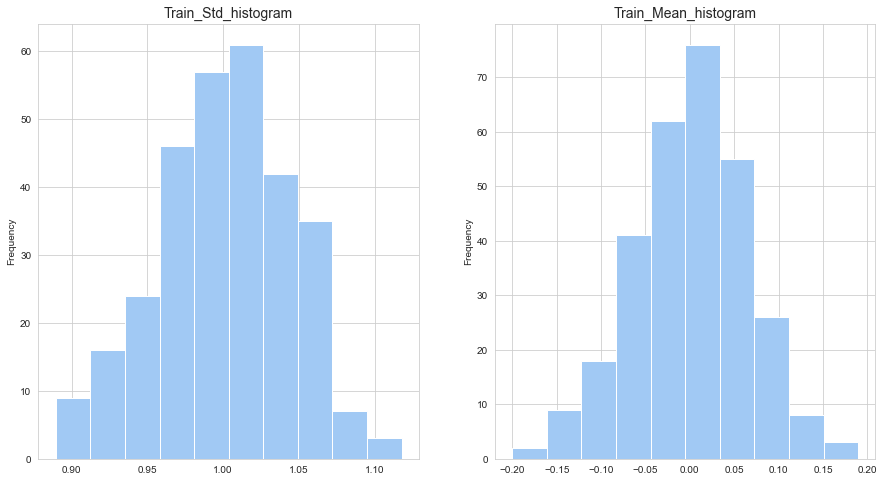

In [3]:
# 데이터 분포 확인

f,ax=plt.subplots(1,2,figsize=(15,8))
train[train.columns[2:]].std().plot(kind='hist',ax=ax[0])
train[train.columns[2:]].mean().plot(kind='hist',ax=ax[1])
ax[0].set_title('Train_Std_histogram' , fontsize = 14)
ax[1].set_title('Train_Mean_histogram' , fontsize = 14)

plt.show()
# 각 칼럼 300개를 하나씩 볼수는 없으므로 칼럼별로 std,mean값을 구해본다, 

- 데이터가 선형성을 띄고있는듯 하다.
- 선형 모델링을 진행해야겠다.

In [4]:
# 널값이 있나? checking!

train.isnull().any().any()

# column 수가 많을 때 any().any()가 효과적인듯하다.

False

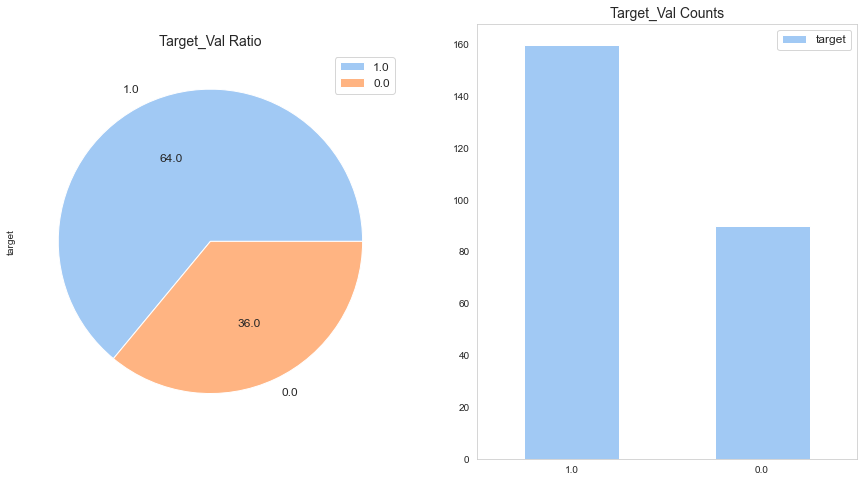

In [5]:
# target값이 어떤 분포인가? 확인

f,ax=plt.subplots(1,2,figsize=(15,8))
train['target'].value_counts().plot(kind = 'pie', autopct = '%.1f', fontsize = 12, ax = ax[0])
ax[0].legend(fontsize = 12, loc='upper right')
ax[0].set_title('Target_Val Ratio', fontsize = 14)

train['target'].value_counts().plot(kind = 'bar',ax = ax[1])
# seaborn으로 바꾸자
ax[1].legend(fontsize = 12, loc='upper right')
ax[1].set_title('Target_Val Counts' , fontsize = 14)
plt.xticks(rotation=0)

plt.grid()
plt.show()

# target의 값이 0, 1로 이진분류이다.
# 0과 1의 차이가 조금 있는것으로 확인된다.

In [6]:
# 각 변수간의 상관관계

corrs = train.corr().abs().unstack().sort_values().reset_index() 
print('corrs의 형태' , corrs.shape)
# train의 corr을 절대값으로 표현하고 메트릭스형태를 unstack으로 풀음

corrs = corrs[corrs['level_0'] != corrs['level_1']] # level_0과 level_1의 동일한 것들은 제거
print('제거후 corrs의 형태' , corrs.shape)

corrs.tail(10) # 높은 상관관계가 보이지 않는다. 제일 높은 것은 0.3375

corrs의 형태 (91204, 3)
제거후 corrs의 형태 (90902, 3)


,level_0,level_1,0
90892,22,28,0.246062
90893,28,22,0.246062
90894,193,101,0.252825
90895,101,193,0.252825
90896,75,32,0.259315
90897,32,75,0.259315
90898,target,65,0.293846
90899,65,target,0.293846
90900,33,target,0.373608
90901,target,33,0.373608


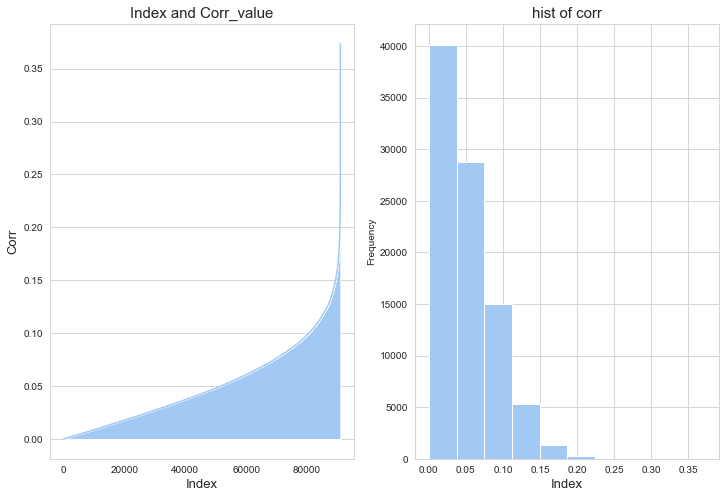

In [7]:
f,ax = plt.subplots(1,2,figsize=(12,8))
ax[0] = corrs[0].plot(ax=ax[0])

ax[0].fill_between(corrs.index, corrs[0].values)
ax[0].set_title('Index and Corr_value', fontsize = 15)
ax[0].set_xlabel('Index', fontsize = 13)
ax[0].set_ylabel('Corr', fontsize = 13)
ax[0].grid(axis = 'x', linestyle = '')

ax[1] = corrs[0].plot(kind='hist')
ax[1].set_title('hist of corr', fontsize = 15)
ax[1].set_xlabel('Index', fontsize = 13)

plt.show()

- 상관도가 뒤로 갈수록 급격하게 늘어난다. 상관도로 변수를 걸러내면 괜찮을듯도 하다.
- 히스토그램을 보면 상관도가 낮은쪽이 훨신 많이 분포한다. 데이터가 서로 상관도가 많이 없다는 뜻이다.

### 이상치 탐색
- Isolation Tree
- LOF(Local Outlier Factor)

In [8]:
from sklearn.ensemble import IsolationForest # 

isf = IsolationForest(n_jobs = -1, random_state=1)
isf.fit(train[train.columns[2:]], train['target'])

print(isf.score_samples(train[train.columns[2:]]))

[-0.44290478 -0.42337535 -0.4407197  -0.41982419 -0.441476   -0.46078608
 -0.44977351 -0.43201255 -0.42839697 -0.43147794 -0.43076223 -0.43028315
 -0.44449772 -0.43871221 -0.426031   -0.44357505 -0.42682374 -0.43153338
 -0.43741902 -0.44234953 -0.447202   -0.44110904 -0.42522819 -0.45786977
 -0.43489759 -0.4229952  -0.4220207  -0.4197649  -0.45198538 -0.43388156
 -0.44168207 -0.41804817 -0.44236878 -0.43249966 -0.45039007 -0.42630854
 -0.43546239 -0.4512928  -0.44274703 -0.43680303 -0.42344098 -0.44110128
 -0.44138941 -0.42701886 -0.43276686 -0.44780405 -0.4431574  -0.41618213
 -0.42732207 -0.42307962 -0.44921204 -0.45534267 -0.44349547 -0.41673312
 -0.43839842 -0.42730584 -0.43637383 -0.41964477 -0.4384621  -0.43182931
 -0.44685683 -0.45978893 -0.44951934 -0.44614166 -0.44192615 -0.44444833
 -0.43648366 -0.45294555 -0.42334903 -0.42266072 -0.4240447  -0.44426499
 -0.44067637 -0.43466456 -0.43556283 -0.44576367 -0.43070218 -0.43136954
 -0.42903861 -0.42031502 -0.43535933 -0.44786619 -0

In [9]:
isf.predict(train[train.columns[2:]]) 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

- isolation tree 기준 이상치는 없다고 한다.

### 예측모델링
- 데이터가 선형성을 띄고있어 로지스틱회귀로 모델 선정
- standard scaling -> 로지스틱 회귀의 하이퍼 파라메터 튜닝
- rfe로 변수 추출

In [10]:
from sklearn.model_selection import StratifiedKFold # 기존 KFold와 다르게 타깃값의 분포를 유지하면서 KFold
from sklearn.preprocessing import StandardScaler # 스케일 조정
from sklearn.model_selection import cross_val_score , cross_val_predict # 교차검증
from sklearn.metrics import confusion_matrix, roc_auc_score  # 혼돈행렬, roc_auc_score, roc 
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
X, y = train.drop(['id','target'], axis=1), train['target']
test = test.drop(['id'], axis=1) 


scaler  = StandardScaler()
X  = scaler.fit_transform(X)
test = scaler.transform(test)


In [11]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters for Logistic Regression
LRparams = {
    "class_weight":["balanced"],
    "penalty" : ["l2","l1"],
    "tol" : [0.0001,0.0002,0.0003],
    "max_iter": [100,200,300],
    "C" :[0.001,0.01, 0.1, 1, 10, 100],
    "intercept_scaling": [1, 2, 3, 4],
    "solver":["liblinear"],
}
model = LogisticRegression(random_state=42)
rs=RandomizedSearchCV(
    model ,
    param_distributions = LRparams,
    verbose=0, 
    n_jobs=-1, 
    scoring='roc_auc',
    cv = 25, 
    n_iter=100, 
    random_state=42
)
rs.fit(X,y)
print('Model name:{:20}\nBest Score: {:.4f}\nBest Param: {}'.format('Logistic Regression',rs.best_score_, rs.best_params_))

Model name:Logistic Regression 
Best Score: 0.8212
Best Param: {'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 300, 'intercept_scaling': 3, 'class_weight': 'balanced', 'C': 0.1}


In [12]:
from sklearn.feature_selection import RFE

clf = rs.best_estimator_
clf.fit(X,y)

selector = RFE(clf, 25, step=1)
selector.fit(X,y)



RFE(estimator=LogisticRegression(C=0.1, class_weight='balanced',
                                 intercept_scaling=3, max_iter=300,
                                 penalty='l1', random_state=42,
                                 solver='liblinear'),
    n_features_to_select=25)

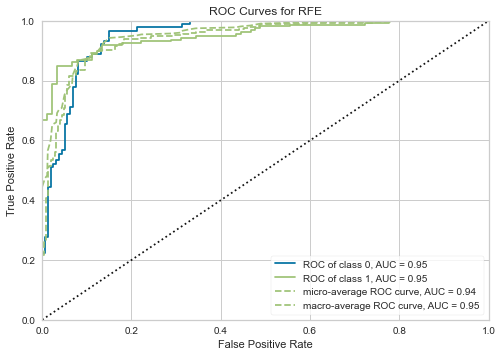

In [13]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(selector, classes=["0", "1"])

visualizer.fit(X, y)
visualizer.score(X, y) 
visualizer.show()   

In [14]:
from sklearn.metrics import roc_auc_score
pred = selector.predict(test)
pred

array([1., 0., 1., ..., 0., 1., 0.])

- Kaggle에 제출 roc_auc 기준 75% 나왔다.
- cross val보다는 적지만 나름 만족한다.
- basic 로지스틱 회귀는 60%대가 나왔다.

### 참고사항
- t-test로 변수를 선택할 수 있다.

In [15]:
# t-test로 변수

from scipy.stats import ttest_ind
X2, y2 = train.drop(['id','target'], axis=1), train['target']
tt_p_val=[]
tt_stat=[]
col2=[]

cols = X2.columns
for i in cols:
    col2.append(i)
    tt_stat.append(ttest_ind(X2[i],y2, equal_var=False)[0])
    tt_p_val.append(ttest_ind(X2[i],y2, equal_var=False)[1])

df2 = pd.DataFrame()
df2['col_name'] = col2
df2['stat'] = tt_stat
df2['p_val'] = tt_p_val
df2.sort_values('p_val').tail()

,col_name,stat,p_val
34,34,-7.095775,7.594389e-12
25,25,-6.926358,2.006082e-11
115,115,-6.816215,4.152589e-11
2,2,-6.617111,1.355906e-10
243,243,-6.035575,4.095074e-09


- p_value가 다 0.05보다 낮네 제거할 변수 없다.
- t-test는 두집단의 비교가 통계적으로 유의한가를 검정
- 두집단의 차이가 우연인지 아닌지 판단

### 🧹질
- pca로 차원축소를 해봤는데 거의 변수가 축소되지않았다.
- 데이터 형태가 거의 다 선형이라서 lda로 차원 축소하면 좋을듯해도 lda로 축소했는데 제출 roc_auc가 낮게 나옴
- eli5, permutation importance를 활용해서 변수 추출하고 모델링했을때 CV는 잘 나왔지만 결과 제출후 basic 로지스틱보다 roc_auc가 안나옴
  * eli5, permutation importance 추출 + SMOTE로 클래스 균형을 맞췄는데 CV는 역시 자나왔지만 제출 roc_auc가 안나옴
  * 알고리즘을 바꿔서 SVM으로 해도 제출 roc_auc 안나와서 원인을 찾는중.. eli5, permutation importance부터 제출 roc_auc가 안나오니<br>여기부터가 문제인듯하다